# Experiments for our embedding
- Each Note in this notebook is a short note on how our embedding perform better than the orig_glove 
- (This is the same notebook on your github with minor changes)


# [EDITED] Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases  in Word Embeddings But do not Remove Them

For a detailed explanation of the experiments in this notebook, see:
[paper](https://arxiv.org/pdf/1903.03862.pdf "Lipstick on a Pig paper")

This notebook uses the debiased embeddings as per **our own novel method**

## Preprocessing

### Load embeddings

In [1]:
import codecs
import numpy as np
from numpy import linalg as LA

def load_embeddings_from_np(filename):
    print('loading ...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i


def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv


def load_and_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')

In [2]:
!ls  ../my_embs/
#all3_full is the embedding we created by our method which, as we showcase below performs better than original 
# glove and gn_glove embeddings in the experiments formulated below

all3_full.vocab  all3_full.wv.npy


In [3]:
vocab = {}
wv = {}
w2i = {}

load_and_normalize('bef', '../hila_paper/gender_bias_lipstick/data/embeddings/orig_glove', vocab, wv, w2i)
load_and_normalize('aft', '../my_embs/all3_full', vocab, wv, w2i) #We load our embeddings

loading ...
done
loading ...
done


In [54]:
from tqdm import tqdm as tqdm

def topK(w, space, k=10):
    
    # extract the word vector for word w
    idx = w2i[space][w]
    vec = wv[space][idx, :]
    
    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [vocab[space][i] for i in best if i!=idx]


def similarity(w1, w2, space):
    
    i1 = w2i[space][w1]
    i2 = w2i[space][w2]
    vec1 = wv[space][i1, :]
    vec2 = wv[space][i2, :]

    return np.inner(vec1,vec2)



### Restrict vocabulary

In [7]:
import string 


def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(space, exclude = None):
    vocab_limited = []
    for w in tqdm(vocab[space][:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    wv_limited = np.zeros((len(vocab_limited), 300))
    for i,w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w],:]
    
    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}
    
    return vocab_limited, wv_limited, w2i_limited


def load_vocab(vocab, space, exclude = None):
    vocab_limited = vocab
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    wv_limited = np.zeros((len(vocab_limited), 300))
    for i,w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w],:]
    
    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}
    
    return vocab_limited, wv_limited, w2i_limited


In [55]:
# create the reduced vocabularies and embeddings before and after, without gendered specific words
import json
data_path = "../hila_paper/gender_bias_lipstick/data/"
with codecs.open(f'{data_path}lists/gender_specific_full.json') as f:
    gender_specific = json.load(f)
with codecs.open(f'{data_path}lists/definitional_pairs.json') as f:
    definitional_pairs = json.load(f)
with codecs.open(f'{data_path}lists/equalize_pairs.json') as f:
    equalize_pairs = json.load(f)

exclude_words = []
for pair in definitional_pairs + equalize_pairs:
    exclude_words.append(pair[0])
    exclude_words.append(pair[1])

exclude_words = list(set(exclude_words).union(set(gender_specific)))

# create spaces of limited vocabulary
vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words)

assert(vocab['limit_aft'] == vocab['limit_bef'])


100%|██████████| 50000/50000 [00:00<00:00, 528299.11it/s]


size of vocabulary: 47705
size of vocabulary: 47705


### Compute bias-by-projection

In [56]:
# create a dictionary of the bias, before and after

def compute_bias_by_projection(space_to_tag, full_space):
    males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
    females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
    d = {}
    for w,m,f in zip(vocab[space_to_tag], males, females):
        d[w] = m-f
    return d

# compute bias-by-projection before and after debiasing
gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')


In [57]:
# calculate the avg bias of the vocabulary (abs) before and after debiasing

def report_bias(gender_bias):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias/len(gender_bias))
report_bias(gender_bias_bef)
report_bias(gender_bias_aft)

0.0375484088337468
0.002161566163504135


#### Note #1: 
Bias by projection is more than ten times less in our embeddings compared to the original glove embedding. As shown above.

## Experiments

### Coreelation between bias-by-projection and bias-by-neighbors

In [58]:
# get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)
# We have "fixed" the functio below. While calculating the correlation, it now considers the bias-by-projection of the new embedding
def bias_by_neighbors(space, neighbours_num = 100, time='before'):
    
    tuples = []
    for w in tqdm(vocab[space]):
        
        top = topK(w, space, k=neighbours_num+5)[:neighbours_num]

        m = 0
        f = 0    
        for t in top:
            if time == 'before':
                if gender_bias_bef[t] > 0:
                    m+=1
                else:
                    f+=1
            else:
                if gender_bias_aft[t] > 0:
                    m+=1
                else:
                    f+=1
            
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))

    return tuples
        
tuples_bef = bias_by_neighbors('limit_bef', time='before') 
tuples_aft = bias_by_neighbors('limit_aft', time='after')       


100%|██████████| 47705/47705 [06:55<00:00, 114.92it/s]


In [13]:
# compute correlation between bias-by-projection and bias-by-neighbors

import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    print(pearson(a,b))

compute_corr(tuples_bef, 1, 3)
compute_corr(tuples_aft, 2,3) #We changed (fixed?) the correlation computation. The correlation shall be computed between the new bias and number of male neighbours


(0.7727051179732384, 0.0)
(0.03108970682314688, 1.1065544964357282e-11)


#### Note #2: 
correlation between bias-by-projection and bias-by-neighbors is much less in our embedding compared to the original glove embeddings

### compute ratio
We believe, simple using the number of male neighbours as a metric to measure bias is flawed. This is why we propose a new metric:
- The ratio of number of male neighbours to the number of female neighbours 
- The number of male and female words in the neighbourhood of a stereotypical word shall be more of less equal. i.e their ratio ~= 1
- We show the number of male and female neighbours of few handpicked words below

In [62]:
l = len(tuples_bef)
ratio = 0
for t in tuples_bef:
    ratio += t[3]/(t[4]+1) #+1 to prevent division by zero
print(f"Average ratio of male to female before: {ratio/l}")

l = len(tuples_aft)
ratio = 0
for t in tuples_aft:
    ratio += t[3]/(t[4]+1)
print(f"Average ratio of male to female after: {ratio/l}")

Average ratio of male to female before: 3.2468240203088414
Average ratio of male to female after: 0.994211997852765


The ratio should be close to 1 (equal number of male and female neighbours)

Our embedding has a ratio much closer to 1 compared to the original glove. This means, we have almost equal number of male and female neighbours.

### correlation between bias by projection and bias by ratio

In [63]:
# compute correlation between bias-by-projection and bias-by-neighbors

def compute_corr_bias(tuples, i1):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[3]/(t[4]+1))
    assert(len(a)==len(b))    
    print(pearson(a,b))

compute_corr_bias(tuples_bef, 1)
compute_corr_bias(tuples_aft, 2)


(0.4555386097503853, 0.0)
(0.029240251002946107, 1.6839899640126198e-10)


#### Note #3: 
Again, our new embedding perform better (low correlation) in this experiment

### Following are a few handpicked examples 
- We show the number of male and female words in the neighborhood of each word

In [70]:
hand_picked_words = ['nanny', 'librarian', 'hairdresser', 'receptionist', 'nurse',\
                       'consultant', 'warden', 'archaeologist', 'banker', 'comic',\
                        'warrior', 'skipper', 'captain', 'commander', 'coach']

In [77]:
for word in hand_picked_words:
    for tup_bef, tup_aft in zip(tuples_bef, tuples_aft):
        if(tup_bef[0]==word):
            print(f"[BEFORE] - Word: {word} | #Male neighbours: {tup_bef[3]} | #Female neighbours: {tup_bef[4]} | Ratio: {tup_bef[3]/tup_bef[4]:.2f}")
        if(tup_aft[0]==word):
            print(f"[AFTER] - Word: {word} | #Male neighbours: {tup_aft[3]} | #Female neighbours: {tup_aft[4]} | Ratio: {tup_aft[3]/tup_aft[4]:.2f}")    

[BEFORE] - Word: nanny | #Male neighbours: 6 | #Female neighbours: 94 | Ratio: 0.06
[AFTER] - Word: nanny | #Male neighbours: 47 | #Female neighbours: 53 | Ratio: 0.89
[BEFORE] - Word: librarian | #Male neighbours: 84 | #Female neighbours: 16 | Ratio: 5.25
[AFTER] - Word: librarian | #Male neighbours: 61 | #Female neighbours: 39 | Ratio: 1.56
[BEFORE] - Word: hairdresser | #Male neighbours: 47 | #Female neighbours: 53 | Ratio: 0.89
[AFTER] - Word: hairdresser | #Male neighbours: 45 | #Female neighbours: 55 | Ratio: 0.82
[BEFORE] - Word: receptionist | #Male neighbours: 25 | #Female neighbours: 75 | Ratio: 0.33
[AFTER] - Word: receptionist | #Male neighbours: 39 | #Female neighbours: 61 | Ratio: 0.64
[BEFORE] - Word: nurse | #Male neighbours: 32 | #Female neighbours: 68 | Ratio: 0.47
[AFTER] - Word: nurse | #Male neighbours: 47 | #Female neighbours: 53 | Ratio: 0.89
[BEFORE] - Word: consultant | #Male neighbours: 79 | #Female neighbours: 21 | Ratio: 3.76
[AFTER] - Word: consultant | #Ma

#### Note #4
We want the ratio to be as close to one as possible, clearly the ratio in our embedding is better (closer to unity)

### Clustering Experiment - Visualize clusters of most biased words

In [78]:
# Auxiliary finctions

import matplotlib as mpl
import matplotlib.pyplot as plt
# import mpld3
from cycler import cycler
%matplotlib inline
# mpld3.enable_notebook()
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')

from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs

from sklearn.manifold import TSNE

def visualize(vectors, words, labels, ax, title, random_state=666, num_clusters = 2):
    
    # perform TSNE
    
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    


def cluster_and_visualize(words_old, words_new, X_bef, X_aft, random_state, y_true, num=2):

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words_old, y_pred_bef, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    print('precision bef', sum(correct)/float(len(correct)))
    
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    visualize(X_aft, words_new, y_pred_aft, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    print('precision aft', sum(correct)/float(len(correct)))
    fig.show()
    


precision bef 1.0
precision aft 0.525


/home/timetraveller/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


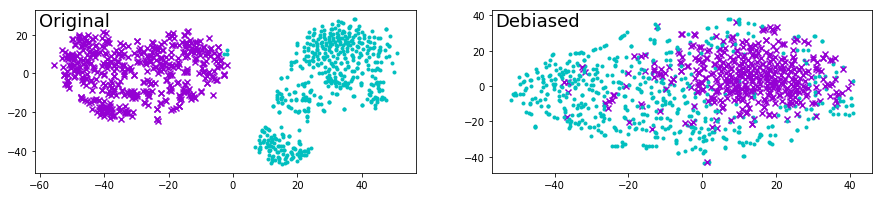

In [80]:
# Cluster most biased words before and after debiasing
import operator
def extract_vectors(words, space = 'limit_bef'):
    """We have again, changed this function. It seem to have miss the new word embedding in the original code"""
    return [wv[space][w2i[space][x],:] for x in words]

random_state = 1

size = 500
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female_old = [item[0] for item in sorted_g[:size]]
male_old = [item[0] for item in sorted_g[-size:]]

sorted_g = sorted(gender_bias_aft.items(), key=operator.itemgetter(1))
female_new = [item[0] for item in sorted_g[:size]]
male_new = [item[0] for item in sorted_g[-size:]]

X_bef = extract_vectors(male_old + female_old)
X_aft = extract_vectors(male_new + female_new)
y_true = [0]*size + [1]*size
cluster_and_visualize(male_old + female_old, male_new + female_new, X_bef, X_aft, random_state, y_true)


#### Note #5
Precision before was perfectly 1, the best precision would be 0.5 (random) and our embedding's neighbourhood is pretty close to 0.5 (0.525)

### Professions experiment

In [81]:
def extract_professions():
    professions = []
    with codecs.open(f'{data_path}lists/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions
professions = extract_professions()


In [82]:
import scipy.stats

def get_tuples_prof(space, words, gender_bias_dict):

    tuples = []
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        top = topK(w, space, k=105)[:100]
            
        m = 0
        f = 0  
        for t in top:          
            if gender_bias_dict[t] > 0:
                m+=1
            else:
                f+=1
                
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))
        
    return tuples


tuples_bef_prof = get_tuples_prof('limit_bef', professions, gender_bias_bef)
tuples_aft_prof = get_tuples_prof('limit_aft', professions, gender_bias_aft) #Earlier this was: gender_bias_bef which needs to be changed to gender_bias_aft

compute_corr(tuples_bef_prof, 1, 3)
compute_corr(tuples_aft_prof, 2, 3) #This was 1,3 earlier which might be wrong.



(0.8074862717809002, 4.4251007990361096e-61)
(0.07933734876985704, 0.20226564887766948)


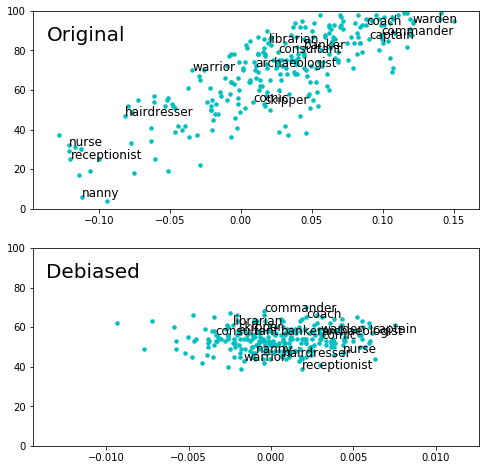

In [83]:
# Show plots
def show_plots(tuples_bef_prof, tuples_aft_prof):
    
    fig, axs = plt.subplots(2,1, figsize=(8,8))
    
    for i,(tuples, title) in enumerate(zip([tuples_bef_prof, tuples_aft_prof], ['Original', 'Debiased'])):
        X = []
        Y = []
        for t in tuples:
            if i==0:
                X.append(t[1])
            else:
                X.append(t[2]) #Fixed even this
            Y.append(t[3])

        axs[i].scatter(X,Y, color = 'c', s=12)
        axs[i].set_ylim(0,100)
        
        for t in tuples:
            if t[0] in ['nanny', 'librarian', 'hairdresser', 'receptionist', 'nurse',\
                       'consultant', 'warden', 'archaeologist', 'banker', 'comic',\
                        'warrior', 'skipper', 'captain', 'commander', 'coach']:
                if i==0:
                    axs[i].annotate(t[0], xy=(t[1], t[3]), xytext=(t[1], t[3]), textcoords="data", fontsize=12) 
                else:    
                    axs[i].annotate(t[0], xy=(t[2], t[3]), xytext=(t[2], t[3]), textcoords="data", fontsize=12) 
        axs[i].text(.03, .85, title, transform=axs[i].transAxes, fontsize=20)
    
    
    fig.show()
    

show_plots(tuples_bef_prof, tuples_aft_prof)


#### Note #6
Again, there seem to be no correlation between the number of male neighbours of each profession. Our embedding perform exceptionally well here 

### Classification experiment

In [84]:
# take 5000 most biased words, split each polarity randomly to train (1/5) and test (4/5), and predict

from sklearn import svm
from random import shuffle
import random
random.seed(10)



def train_and_predict(space_train, space_test):
    
    X_train = [wv[space_train][w2i[space_train][w],:] for w in males[:size_train]+females[:size_train]]
    Y_train = [1]*size_train + [0]*size_train
    X_test = [wv[space_test][w2i[space_test][w],:] for w in males[size_train:]+females[size_train:]]
    Y_test = [1]*size_test + [0]*size_test

    clf = svm.SVC()
    clf.fit(X_train, Y_train)

    print( 'train with', space_train)
    print('test with', space_test)

    preds = clf.predict(X_test)

    accuracy = [1 if y==z else 0 for y,z in zip(preds, Y_test)]
    print('accuracy:', float(sum(accuracy))/len(accuracy))

    
# extract nost biased words

size_train = 500
size_test = 2000
size = size_train + size_test
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
males = [item[0] for item in sorted_g[-size:]]
for f in females:
    assert(gender_bias_bef[f] < 0)
for m in males:
    assert(gender_bias_bef[m] > 0)
shuffle(females)
shuffle(males)

# classification before debiasing

train_and_predict('bef', 'bef')

# classification after debiasing

train_and_predict('aft', 'aft')


/home/timetraveller/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train with bef
test with bef
accuracy: 0.998


/home/timetraveller/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train with aft
test with aft
accuracy: 0.789


#### Note #7
In this experiment too our embedding perform better (lower the accuracy, less biased the embedding)